# Оптимизация и расчет стоимости электроэнергии

Цели:

- Получить скорректированный почасовый график общего потребления полезной нагрузкой и накопителем.
- Построить почасовой график нагрузки накопителя.
- Определить стоимость электроэнергии и мощности при фактическом графике потребления.
- Определить стоимость электроэнергии и мощности при скорректированном графике потребления.
- Снизить затраты электроэнергии.

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import scipy
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm, notebook

import warnings
warnings.filterwarnings("ignore", message="delta_grad == 0.0. Check if the approximated function is linear.")

pd.options.display.float_format = '{:0.3f}'.format
pd.options.mode.chained_assignment = None
pd.set_option('display.expand_frame_repr', False)

sns.set_theme(context='paper',
              palette='muted',
              style='whitegrid',
              font_scale=1.1,)

plt.rcParams.update({'lines.linewidth': 1.25,
                     'grid.linewidth': 0.5,
                     'grid.alpha': 0.5,
                     'figure.constrained_layout.use': True,
                     'figure.figsize': (10, 6)})

%config InlineBackend.figure_format = 'retina'

## Исходные данные

In [2]:
excel_file_name = 'input-orignal.xlsx'

In [3]:
config = pd.read_excel(excel_file_name, sheet_name='config',
                       usecols=[2, 3], nrows=9, skiprows=7,
                       names=['specification','value'])

# Переведём все размерности в киловатты.
config.iloc[[2,3,4,6], 1] = config.iloc[[2,3,4,6], 1] * 1000
config.iloc[[-2, -1], 1] = config.iloc[[-2, -1], 1] / 1000
config.loc[9] = ['Цена мощности (товар)', 353.76 / 1000]
config

,specification,value
0,"Тип тарифа (1-одноставочный, 2-двуставочный)",2.000
1,Количество моделируемых периодов,744.000
2,Максимальная технологическая емкость накопителя,5930.000
3,Максимальная мощность накопителя на выдачу,2000.000
4,Максимальная мощность накопителя на прием (-),-2500.000
5,КПД накопителя,0.950
6,Накопленный заряд в перед началом первого периода,1000.000
7,Цена мощности - Электроэнергия и мощность (товар),629.149
8,Цена мощности - Услуга по передаче,948.520
9,Цена мощности (товар),0.354


In [4]:
# Тариф на передучу электроэнергии - ДвуставочныйW СН-II
tariff_w_ch2 = config.iloc[9,1]
tariff_p_ch2 = config.iloc[8,1]
tariff_p = config.iloc[7,1]

# Выходные и рабочие дни в отведенный период.
days = pd.DataFrame({'date': pd.date_range(start="2018-12-01", end="2018-12-31")})
days['is_day_off'] = days.date.dt.weekday >= 5
days.iloc[-3, 1] = False
days.iloc[-1, 1] = True
# Добавим час максимального совокупного потребления электроэнергии в субъекте Российской Федерации.
days = days.merge(how='left', right=pd.read_excel(excel_file_name, sheet_name='Пиковый час',
                                                  skiprows=9,
                                                  names=['date', 'is_max_hour']))

# Плановые пиковые часы в декабре 2018 года по 1 ценовой зоне (г. Москва).
peak_hours = pd.read_excel(excel_file_name, sheet_name='Плановые пиковые часы',
                           usecols=[0, 1], skiprows=4, names=['hour', 'is_peak_hour'])
peak_hours['is_peak_hour'] = peak_hours.is_peak_hour.astype(bool)

In [5]:
data = pd.read_excel(excel_file_name, sheet_name='Расчет',
                     skiprows=5,
                     usecols=[0,1,3,4],
                     names=['date', 'hour',
                            'payload', 'electro_price_rsv'])

# Переменная стоимость энергии, руб/кВтч
data['var_energy_cost'] = data['electro_price_rsv'] + tariff_w_ch2

# Объединим данные с days и с peak_hours.
data = data.merge(days, on='date')
data = data.merge(peak_hours, on='hour')
data.sort_values(['date', 'hour'], inplace=True, ignore_index=True)

data['is_max_hour'] = ~data.is_max_hour.where(data.hour == data.is_max_hour).isna()

# Добавим полное время и признак total_load.
data['full_time'] = data.date + data.hour.apply(lambda x: pd.Timedelta(x, 'h'))
data['total_load'] = data.payload

data.head()

,date,hour,payload,electro_price_rsv,var_energy_cost,is_day_off,is_max_hour,is_peak_hour,full_time,total_load
0,2018-12-01,1,1063,1.058,1.411,True,False,False,2018-12-01 01:00:00,1063
1,2018-12-01,2,1061,0.980,1.333,True,False,False,2018-12-01 02:00:00,1061
2,2018-12-01,3,1061,0.944,1.298,True,False,False,2018-12-01 03:00:00,1061
3,2018-12-01,4,1060,0.922,1.275,True,False,False,2018-12-01 04:00:00,1060
4,2018-12-01,5,1061,0.944,1.298,True,False,False,2018-12-01 05:00:00,1061


## Диаграммы размаха для рабочих дней

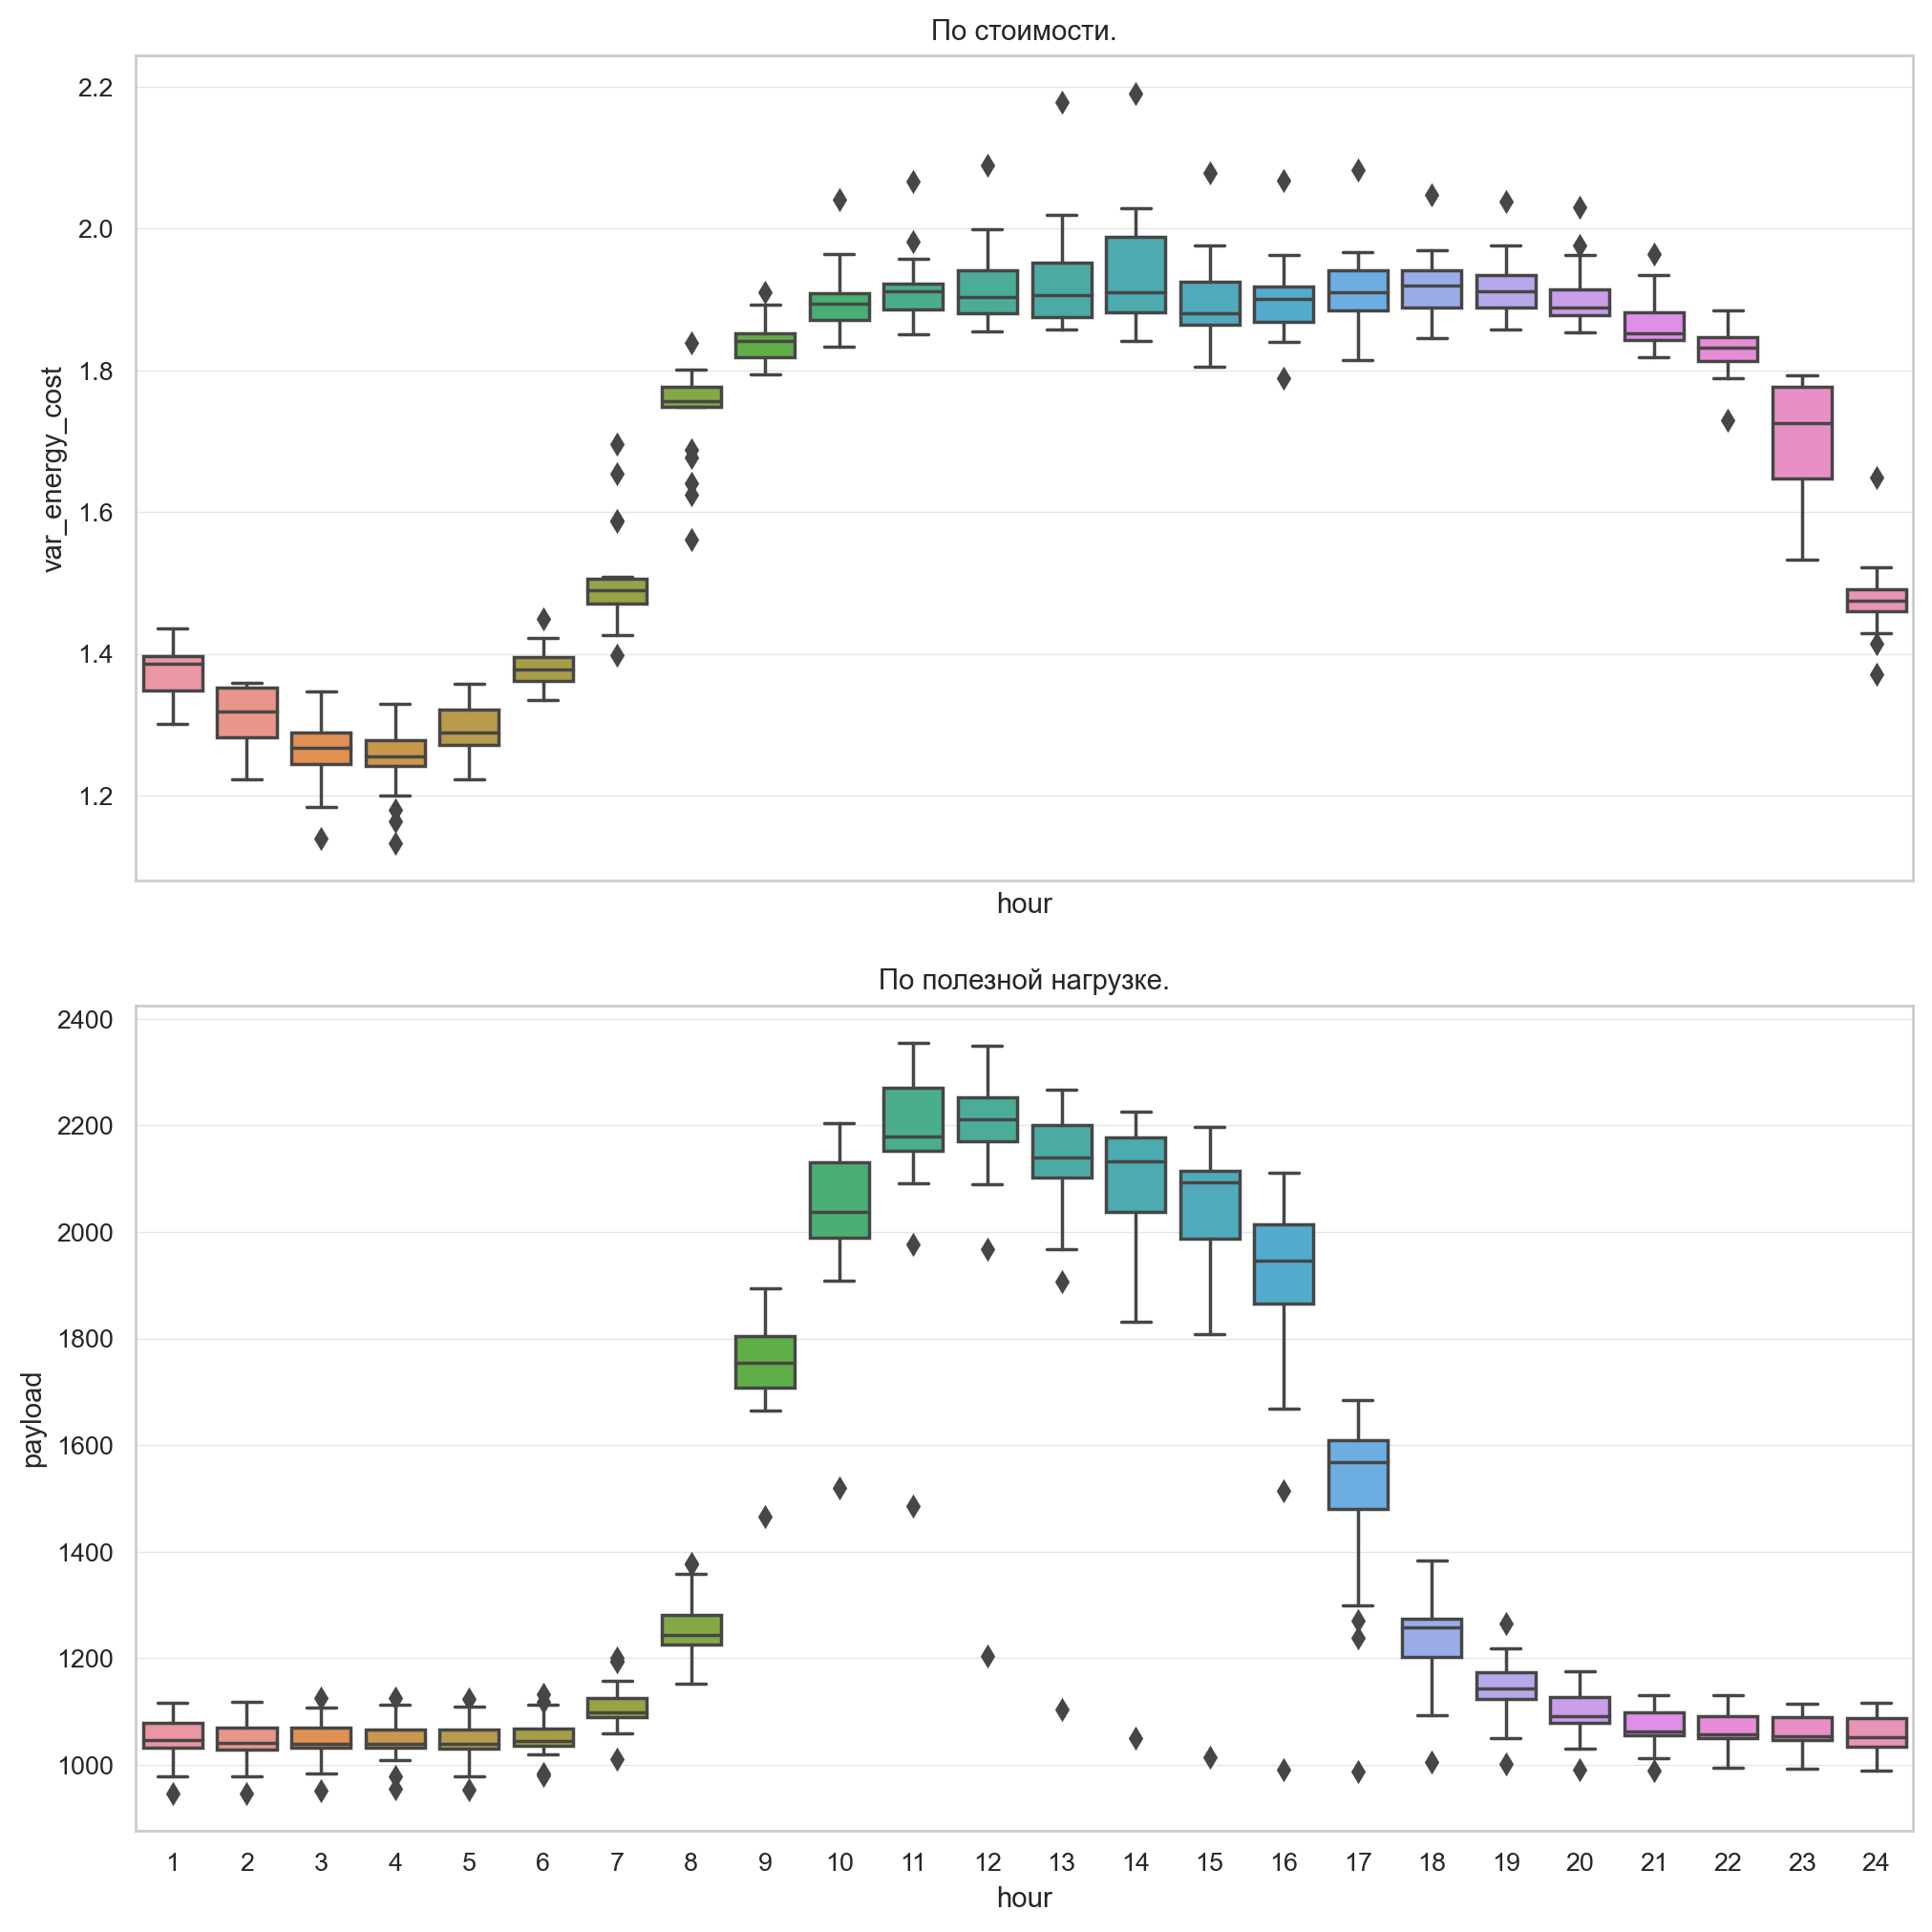

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(10,10),
                         sharex=True, sharey=False)
sns.boxplot(data=data.query('is_day_off == False'),
             y='var_energy_cost', x='hour',
             ax=axes[0]);
sns.boxplot(data=data.query('is_day_off == False'),
             y='payload', x='hour',
             ax=axes[1]);

axes[0].set_title('По стоимости.')
axes[1].set_title('\nПо полезной нагрузке.')

plt.show()

## Алгоритм оптимизации

In [7]:
class consumption_optimization():
    def __init__(self, config=config, maxiter=10000):
        # Максимальное число итераций.
        self.maxiter = maxiter
        
        # Параметры накопителя.
        self.max_distr = config.iloc[3, 1]
        self.max_feed = -config.iloc[4, 1]
        self.capacity = config.iloc[2, 1]
        self.initial_capacity = config.iloc[6, 1]
        self.efficiency = config.iloc[5,1]
        self.loss = 1 - self.efficiency
        
        # Начальные веса.
        self.x0 = np.array([])
        
    def define_constraints(self):
        num, max_distr, max_feed, p = self.num, self.max_distr, self.max_feed, self.p
        capacity, initial_capacity, efficiency = self.capacity, self.initial_capacity, self.efficiency
        
        # Отдаваемая мощность ограничена технически и полезной нагрузкой.
        # 'p' дополнительно делим на КПД ('efficiency').
        max_distr = np.min([max_distr * np.ones(num), p / efficiency], axis=0)

        # Граничные условия для входящей 'a' в накопитель мощности («зарядка напопителя»)
        # и исходящей 'b' мощности («разрядка накопителя»).
        # Умножаем на 2, т.к. число параметров равно произведению периодов на 2.
        self.bounds = Bounds(-max_distr, max_feed * np.ones(num))

        # Определим ограничения в виде объекта LinearConstraint.
        # Последнее условие нужно чтобы алгоритм не оставлял заряд на конец периода.
        down_border = np.concatenate((
            -initial_capacity * np.ones(num-1),
            [-initial_capacity]))
        up_border = np.concatenate((
            (capacity - initial_capacity) * np.ones(num-1),
            [5 - initial_capacity]))
        self.linear_constraint = LinearConstraint(
            self.const_matrix, down_border, up_border)
    
    def opt_func(self, x):
        p, s, max_hour, peak_hour, working_day = self.p, self.s, self.max_hour, self.peak_hour, self.working_day
        tariff_w_ch2, tariff_p, tariff_p_ch2 = self.tariff_w_ch2, self.tariff_p, self.tariff_p_ch2
        num, loss = self.num, self.loss
                
        p = p + x * (1 - np.signbit(x) * loss)
        
        return (
            np.sum(p * s)
            + np.sum(p * tariff_w_ch2)
            + np.mean((working_day * p * peak_hour).reshape(-1, 24).max(axis=1)) * tariff_p_ch2
            + np.mean(working_day * p * max_hour) * tariff_p
        )
    
    def callback(self, x, res):
        if res['niter'] % 100  == 0:
            print(res['niter'], round(res['optimality']), round(res['fun']))
    
    def start_calculation(self, group):
        # Входные параметры.
        self.p = group.payload.values
        self.s = group.electro_price_rsv.values
        self.max_hour = group.is_max_hour.values
        self.peak_hour = group.is_peak_hour.values
        self.working_day = ~group.is_day_off.values
        
        # Величина периода оптимизации кратное 24.
        self.num = group.shape[0]
        num = self.num
        
        # Масштабный коэффициент для оптимицации за периоды отличные от '1M'.
        scale = np.sum(~group.is_day_off.values) / np.sum(~data.is_day_off.values)
        
        # Коэффициент изменяющий tariff_p_ch2 и tariff_p с учетом периода.
        pick_h_k = (~data.is_day_off.values).sum() / data.shape[0]
        max_h_k = ((~data.is_day_off.values).sum() // 24) / data.shape[0]
        
        # Данные по тарифам.
        self.tariff_w_ch2 = config.iloc[9, 1]
        self.tariff_p_ch2 = scale * config.iloc[8, 1] / pick_h_k if pick_h_k != 0 else 0
        self.tariff_p = scale * config.iloc[7, 1] / max_h_k if max_h_k != 0 else 0
        
        # Начальные веса. Конечные веса предыдущего периода являются начальными следующего.
        # Можно использовать результаты предыдущей оптимизации.
        try:
            self.x0 = group.electr_storage_load.values
        except:
            if self.x0.shape[0] != group.shape[0]:
                self.x0 = np.zeros(num)
        
        # Создадим матрицу в которой верхний правый треугольник нулевой.
        e = np.eye(num)
        e[np.tril_indices(e.shape[1])] = 1
        self.const_matrix = e
        
        # Определим граничные условия.
        self.define_constraints()
        
        # Запусr минимизации целевой функции.
        res = minimize(self.opt_func, self.x0,
                       method='trust-constr',
                       constraints=self.linear_constraint,
                       bounds=self.bounds,
                       # callback=self.callback,
                       options={'maxiter': self.maxiter,
                                'finite_diff_rel_step': 0.00001,
                                'initial_constr_penalty': 20
                               }
                      )
        
        # После первой итерации обнуляем initial_capacity.
        self.initial_capacity = 0
        
        return res

Используем алгоритм для оптимизации работы накопителя и уменьшения стоимости электроэнергии (мощности).

In [8]:
# Предварительный тест для одной даты.
data_for_day = data.query('date == "2018-12-17"')
opt = consumption_optimization()
res = opt.start_calculation(data_for_day)

print(res.message, res.fun, res.constr_violation, sep='\n')

`xtol` termination condition is satisfied.
143590.55056500813
0.0


In [9]:
def get_opt_df(data, freq='1D'):
    optimised_data = pd.DataFrame()
    opt = consumption_optimization()

    for lab, df in notebook.tqdm(data.groupby(pd.Grouper(key='date', freq=freq))):
        constr_violation = 100

        # Проверка на решение удовлетворяет заданным ограничениям.
        while constr_violation > 1:
            res = opt.start_calculation(df)
            constr_violation = res.constr_violation

        # В нагрузке отображается полная величина, при этом total_load считается с учетом КПД накопителя.
        df['electr_storage_load'] = res.x
        df['total_load'] = df.payload + res.x * (1 - np.signbit(res.x) * opt.loss)

        optimised_data = pd.concat([optimised_data, df], ignore_index=True)

    optimised_data['electr_storage_сharge'] = optimised_data.electr_storage_load.cumsum()
    optimised_data['electr_storage_сharge'] += config.iloc[6, 1]
    
    return optimised_data

In [10]:
optimised_data_1D = get_opt_df(data, freq='1D')
optimised_data_1D.head(24)

  0%|          | 0/31 [00:00<?, ?it/s]

,date,hour,payload,electro_price_rsv,var_energy_cost,is_day_off,is_max_hour,is_peak_hour,full_time,total_load,electr_storage_load,electr_storage_сharge
0,2018-12-01,1,1063,1.058,1.411,True,False,False,2018-12-01 01:00:00,113.143,-999.849,0.151
1,2018-12-01,2,1061,0.980,1.333,True,False,False,2018-12-01 02:00:00,1061.009,0.009,0.159
2,2018-12-01,3,1061,0.944,1.298,True,False,False,2018-12-01 03:00:00,2777.923,1716.923,1717.082
3,2018-12-01,4,1060,0.922,1.275,True,False,False,2018-12-01 04:00:00,3559.823,2499.823,4216.905
4,2018-12-01,5,1061,0.944,1.298,True,False,False,2018-12-01 05:00:00,2773.909,1712.909,5929.814
5,2018-12-01,6,1063,0.978,1.332,True,False,False,2018-12-01 06:00:00,1063.046,0.046,5929.860
6,2018-12-01,7,1060,0.996,1.350,True,False,False,2018-12-01 07:00:00,1060.104,0.104,5929.964
7,2018-12-01,8,1054,1.105,1.459,True,False,True,2018-12-01 08:00:00,1054.018,0.018,5929.982
8,2018-12-01,9,1036,1.411,1.765,True,False,True,2018-12-01 09:00:00,1035.933,-0.070,5929.911
9,2018-12-01,10,1029,1.453,1.807,True,False,True,2018-12-01 10:00:00,1028.948,-0.055,5929.856


## Результирующие графики

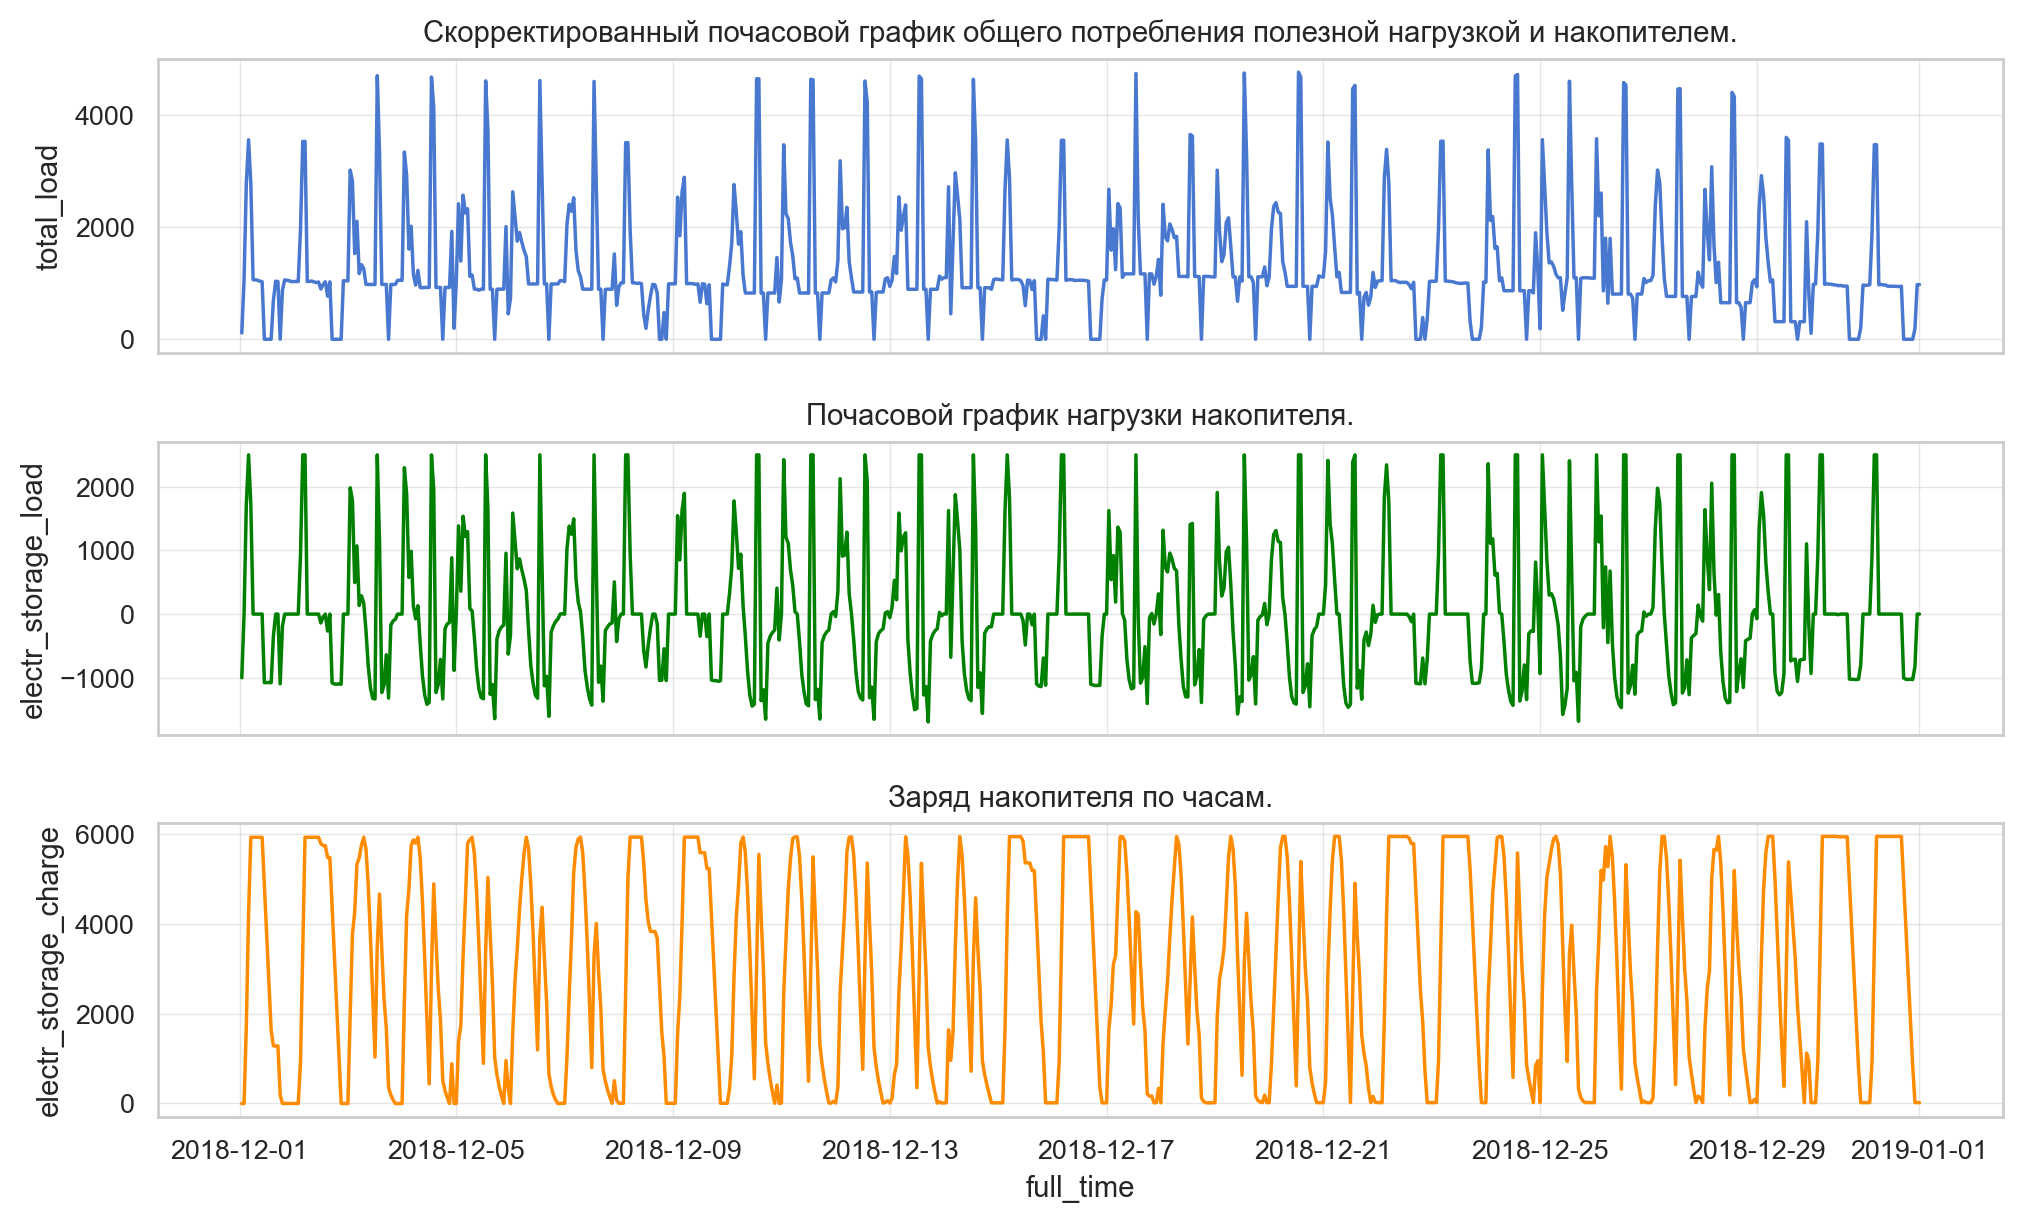

In [11]:
def plot_graphs(df):
    fig, axes = plt.subplots(3, 1, sharex=True, sharey=False)
    sns.lineplot(data=df,
                 y='total_load', x='full_time',
                 ax=axes[0]);
    sns.lineplot(data=df,
                 y='electr_storage_load', x='full_time',
                 color='green', ax=axes[1]);
    sns.lineplot(data=df,
                 y='electr_storage_сharge', x='full_time',
                 color='darkorange', ax=axes[2]);

    axes[0].set_title('Скорректированный почасовой график общего потребления полезной нагрузкой и накопителем.')
    axes[1].set_title('\nПочасовой график нагрузки накопителя.')
    axes[2].set_title('\nЗаряд накопителя по часам.')

    plt.show()

plot_graphs(optimised_data_1D)

# Расчёт затрат

Функции для вывода затрат и результата оптимизации.

In [12]:
def cost_calc(data):
    # Стоимость электроэнергии.
    electricity_costs_product = np.sum(data.total_load * data.electro_price_rsv)

    # Стоимость мощности.
    actual_power_product = \
    round(data.query('is_day_off == False and is_max_hour == True').total_load.mean())
    power_costs_product = actual_power_product * tariff_p
    
    print('Электроэнергия и мощность (товар).')
    print('Стоимость электроэнергии:',
          round(electricity_costs_product, 2))
    print('Стоимость мощности:',
          round(power_costs_product, 2))
    
    # Стоимость электроэнергии.
    electricity_costs_transfer = np.sum(data.total_load * tariff_w_ch2)

    # Стоимость мощности.
    actual_power_transfer = round(data.query('is_day_off == False and is_peak_hour == True').groupby(
        pd.Grouper(key='date', freq='1D')).total_load.max().mean())
    power_costs_transfer = actual_power_transfer * tariff_p_ch2
    
    print('')
    print('Услуга по передаче.')
    print('Стоимость электроэнергии:',
          round(electricity_costs_transfer, 2))
    print('Стоимость мощности:',
          round(power_costs_transfer, 2))
    
    return electricity_costs_product, power_costs_product, electricity_costs_transfer, power_costs_transfer

In [13]:
def opt_res(costs_stock, costs_optimised):
    delta = round(sum(costs_stock) - sum(costs_optimised))
    percent = delta / sum(costs_stock)
    print(f'Результат оптимизации - снижение затрат на {delta:.0f} руб ({percent:.1%}).')

## Стоимость электроэнергии и мощности при фактическом графике потребления

In [14]:
costs_stock = cost_calc(data)

Электроэнергия и мощность (товар).
Стоимость электроэнергии: 1318138.14
Стоимость мощности: 860047.33

Услуга по передаче.
Стоимость электроэнергии: 339430.24
Стоимость мощности: 2075361.36


## Стоимость электроэнергии и мощности при скорректированном графике потребления

In [15]:
costs_optimised = cost_calc(optimised_data_1D)
print('\n')
opt_res(costs_stock, costs_optimised)

Электроэнергия и мощность (товар).
Стоимость электроэнергии: 1236794.62
Стоимость мощности: 0.0

Услуга по передаче.
Стоимость электроэнергии: 344053.61
Стоимость мощности: 843234.12


Результат оптимизации - снижение затрат на 2168895 руб (47.2%).


Используя результаты '1D' как входные данные, проведем повторную оптимизацию за недельный период.

* Неделя в данном случае начинается с воскресенья, что является плюсом, так как возможно снижение затрат за счет добора энергии в воскресенье перед рабочими днями.

In [16]:
optimised_data_1W = get_opt_df(optimised_data_1D, freq='1W')

costs_optimised = cost_calc(optimised_data_1W)
print('\n')
opt_res(costs_stock, costs_optimised)

  0%|          | 0/6 [00:00<?, ?it/s]

Электроэнергия и мощность (товар).
Стоимость электроэнергии: 1238152.58
Стоимость мощности: 0.0

Услуга по передаче.
Стоимость электроэнергии: 344189.79
Стоимость мощности: 806241.85


Результат оптимизации - снижение затрат на 2204393 руб (48.0%).


# Вывод

* Скорректирован график потребления.
* Стоимость электроэнергии снижена на 48%.